In [1]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

#link colab https://colab.research.google.com/drive/1NL2J6q2-dkpD0KmtZR2uCPUjiFXukIt4#scrollTo=31_7OBGm9n4z


--2025-01-03 16:05:35--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-03 16:05:35--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  9.88MB/s    in 5m 3s   

2025-01-03 16:10:39 (12.6 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-03 16:10:39--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request s

In [2]:
import zipfile
import os

# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))


Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


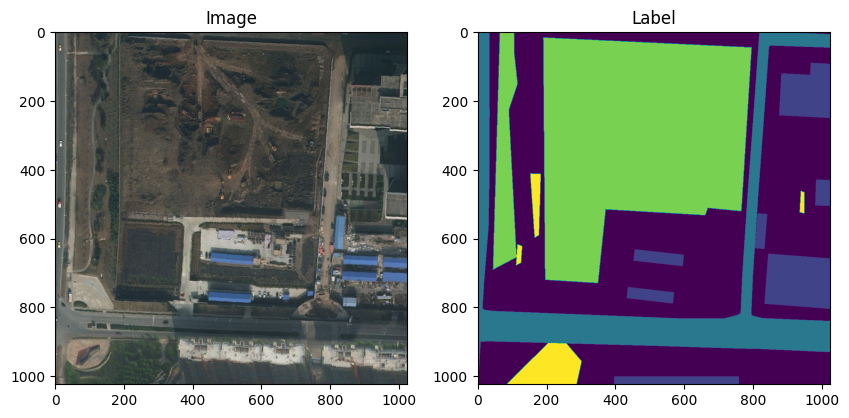

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()


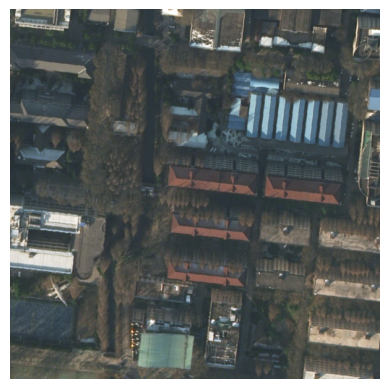

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os




# Example grayscale values
COLOR_MAP = {
    'class1': 0.00392157,
    'class2': 0.00784314,
    'class3': 0.01176471,
    'class4': 0.01568628,
    'class5': 0.01960784,
    'class6': 0.02352941,
    'class7': 0.02745098
}

# Map class names to indices
LABEL_MAP = {k: v for v, k in enumerate(COLOR_MAP.keys())}

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)

# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=2):
    """ Display the mask using matplotlib. """
    # Convert the mask to a numpy array and display as a 2D image
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    plt.imshow(mask)  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label

        # Image and Label paths
        self.image_paths = []
        self.label_paths = []

        for subdir in ['Urban', 'Rural']:  # Handling both 'Urban' and 'Rural'
            image_dir = os.path.join(root_dir, split, subdir, 'images_png')
            label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

            for f in os.listdir(image_dir):
                if f.endswith('.png'):  # Assuming the files are PNG images
                    self.image_paths.append(os.path.join(image_dir, f))
                    self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.transform_image:
            image = self.transform_image(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

# Define transformations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Create dataset and dataloader
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        #show_mask(label[0])
        break


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
!pip install thop
from thop import profile, clever_format #used at the end
import os

import numpy as np

In [6]:
!git clone https://github.com/XuJiacong/PIDNet.git



Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 26.24 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [7]:
!pip install torch torchvision thop opencv-python tqdm numpy scipy #manually install the necessary libraries:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [8]:
import sys
sys.path.append('/content/PIDNet') #è utile se si ha un modulo che non è installato nelle cartelle di ricerca predefinite di Python, ma si trova in una cartella personalizzata o diversa. la directory /content/PIDNet è aggiunta alla lista di ricerca, in modo che Python possa importare moduli da questa cartella.

In [9]:
from models.pidnet import get_pred_model
from models.pidnet import get_seg_model

# Initialize PIDNet-S model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = get_pred_model(name='pidnet_s', num_classes=7).to(device)
model = get_seg_model(cfg='pidnet_s', num_classes=7).to(device)


In [10]:
num_classes=7
# mIoU calculation function
def compute_mIoU(preds, labels, num_classes):
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)

    preds = preds.argmax(dim=1)  # Get the class with the highest score for each pixel
    for i in range(num_classes):
        intersection[i] = torch.sum((preds == i) & (labels == i)).float()
        union[i] = torch.sum((preds == i) | (labels == i)).float()

    IoU = intersection / (union + 1e-6)
    mIoU = IoU.mean()
    return mIoU


In [11]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # You can adjust the learning rate
criterion = nn.CrossEntropyLoss()

In [12]:
import torch.nn.functional as F
import torch

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        outputs = model(images)

        # Upsample model outputs to match the target resolution (512x512)
        outputs = F.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

        # Ensure masks are in the right shape and type (long)
        masks = masks.squeeze(1)  # Remove extra channel dimension and convert to long

        # Calculate loss
        loss = criterion(outputs, masks)  # Use CrossEntropyLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #print(f"running Loss: {running_loss:.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

     # Validation phase
    model.eval()
    val_loss = 0.0
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Upsample the outputs to match the target resolution
            outputs = F.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

            # Ensure masks are in the right shape and type (long)
            masks = masks.squeeze(1)

            # Calculate loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate mIoU incrementally
            preds = outputs.argmax(dim=1).detach()  # Detach to prevent GPU memory buildup
            masks = masks.argmax(dim=1).detach()
            for i in range(num_classes):
                intersection[i] += torch.sum((preds == i) & (masks == i)).float()
                union[i] += torch.sum((preds == i) | (masks == i)).float()

            # Free GPU memory
            del outputs, preds, masks
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Calculate mIoU
    IoU = intersection / (union + 1e-6)  # Avoid division by zero
    mIoU = IoU.mean()
    print(f"Validation mIoU: {mIoU:.4f}")





Epoch 1/20: 100%|██████████| 1261/1261 [04:40<00:00,  4.49it/s]


Epoch [1/20] Loss: 1.5659


Validation: 100%|██████████| 835/835 [02:29<00:00,  5.60it/s]


Validation Loss: 1.7466
Validation mIoU: 0.1477


Epoch 2/20: 100%|██████████| 1261/1261 [04:34<00:00,  4.59it/s]


Epoch [2/20] Loss: 1.4198


Validation: 100%|██████████| 835/835 [02:23<00:00,  5.82it/s]


Validation Loss: 1.6608
Validation mIoU: 0.1803


Epoch 3/20: 100%|██████████| 1261/1261 [04:29<00:00,  4.69it/s]


Epoch [3/20] Loss: 1.3409


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.91it/s]


Validation Loss: 3.4418
Validation mIoU: 0.1556


Epoch 4/20: 100%|██████████| 1261/1261 [04:30<00:00,  4.67it/s]


Epoch [4/20] Loss: 1.3190


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.91it/s]


Validation Loss: 1.9794
Validation mIoU: 0.1961


Epoch 5/20: 100%|██████████| 1261/1261 [04:28<00:00,  4.70it/s]


Epoch [5/20] Loss: 1.2453


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.88it/s]


Validation Loss: 1.4210
Validation mIoU: 0.2425


Epoch 6/20: 100%|██████████| 1261/1261 [04:27<00:00,  4.71it/s]


Epoch [6/20] Loss: 1.1687


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.89it/s]


Validation Loss: 2.8305
Validation mIoU: 0.1929


Epoch 7/20: 100%|██████████| 1261/1261 [04:30<00:00,  4.67it/s]


Epoch [7/20] Loss: 1.0970


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.89it/s]


Validation Loss: 1.3879
Validation mIoU: 0.2437


Epoch 8/20: 100%|██████████| 1261/1261 [04:30<00:00,  4.65it/s]


Epoch [8/20] Loss: 1.0742


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.89it/s]


Validation Loss: 1.5068
Validation mIoU: 0.2357


Epoch 9/20: 100%|██████████| 1261/1261 [04:34<00:00,  4.60it/s]


Epoch [9/20] Loss: 1.0111


Validation: 100%|██████████| 835/835 [02:22<00:00,  5.85it/s]


Validation Loss: 1.4330
Validation mIoU: 0.2407


Epoch 10/20: 100%|██████████| 1261/1261 [04:32<00:00,  4.62it/s]


Epoch [10/20] Loss: 0.9755


Validation: 100%|██████████| 835/835 [02:20<00:00,  5.94it/s]


Validation Loss: 2.1426
Validation mIoU: 0.2382


Epoch 11/20: 100%|██████████| 1261/1261 [04:29<00:00,  4.69it/s]


Epoch [11/20] Loss: 0.9730


Validation: 100%|██████████| 835/835 [02:22<00:00,  5.85it/s]


Validation Loss: 1.9133
Validation mIoU: 0.2460


Epoch 12/20: 100%|██████████| 1261/1261 [04:29<00:00,  4.68it/s]


Epoch [12/20] Loss: 0.9772


Validation: 100%|██████████| 835/835 [02:20<00:00,  5.95it/s]


Validation Loss: 7.7969
Validation mIoU: 0.2064


Epoch 13/20: 100%|██████████| 1261/1261 [04:30<00:00,  4.66it/s]


Epoch [13/20] Loss: 0.9064


Validation: 100%|██████████| 835/835 [02:22<00:00,  5.86it/s]


Validation Loss: 1.3797
Validation mIoU: 0.3032


Epoch 14/20: 100%|██████████| 1261/1261 [04:26<00:00,  4.73it/s]


Epoch [14/20] Loss: 0.8961


Validation: 100%|██████████| 835/835 [02:20<00:00,  5.95it/s]


Validation Loss: 1.4108
Validation mIoU: 0.2992


Epoch 15/20: 100%|██████████| 1261/1261 [04:28<00:00,  4.70it/s]


Epoch [15/20] Loss: 0.8637


Validation: 100%|██████████| 835/835 [02:19<00:00,  5.97it/s]


Validation Loss: 1.3927
Validation mIoU: 0.2938


Epoch 16/20: 100%|██████████| 1261/1261 [04:29<00:00,  4.68it/s]


Epoch [16/20] Loss: 0.8653


Validation: 100%|██████████| 835/835 [02:19<00:00,  5.97it/s]


Validation Loss: 1.4053
Validation mIoU: 0.2880


Epoch 17/20: 100%|██████████| 1261/1261 [04:28<00:00,  4.70it/s]


Epoch [17/20] Loss: 0.8591


Validation: 100%|██████████| 835/835 [02:20<00:00,  5.95it/s]


Validation Loss: 1.4149
Validation mIoU: 0.2987


Epoch 18/20: 100%|██████████| 1261/1261 [04:27<00:00,  4.71it/s]


Epoch [18/20] Loss: 0.8514


Validation: 100%|██████████| 835/835 [02:19<00:00,  6.00it/s]


Validation Loss: 1.5898
Validation mIoU: 0.2985


Epoch 19/20: 100%|██████████| 1261/1261 [04:27<00:00,  4.71it/s]


Epoch [19/20] Loss: 0.8285


Validation: 100%|██████████| 835/835 [02:21<00:00,  5.90it/s]


Validation Loss: 1.2113
Validation mIoU: 0.3287


Epoch 20/20: 100%|██████████| 1261/1261 [04:28<00:00,  4.69it/s]


Epoch [20/20] Loss: 0.8657


Validation: 100%|██████████| 835/835 [02:20<00:00,  5.94it/s]

Validation Loss: 1.4527
Validation mIoU: 0.2665


In [13]:
import time
# Performance Evaluation (Latency, FLOPs, and Parameters)
print("\nEvaluating Model Performance:")

# Measure latency
dummy_input = torch.randn(1, 3, 512, 512).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    model(dummy_input)
    end_time = time.time()
latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

# Compute FLOPs and Params
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"Params: {params}")

# Optionally, print class-wise IoU
print("\nClass-wise IoU:")
IoU = intersection / (union + 1e-6)
for i, iou in enumerate(IoU):
    print(f"Class {i+1} IoU: {iou:.4f}")



Evaluating Model Performance:
Latency: 10.16 ms
FLOPs: 5.960G
Params: 7.624M

Class-wise IoU:
Class 1 IoU: 0.3725
Class 2 IoU: 0.2863
Class 3 IoU: 0.3185
Class 4 IoU: 0.3227
Class 5 IoU: 0.0350
Class 6 IoU: 0.2369
Class 7 IoU: 0.2936
